In [7]:
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

In [8]:
qiskit.__version__


'1.2.0'

In [26]:
## Now we will define functions to create the randomised product state

def random_statevector(theta, phi):
    rand_st = np.cos(theta/2)*Statevector.from_label('0') + np.exp(1j*phi)*np.sin(theta/2)*Statevector.from_label('1')
    return rand_st

def random_product_state(N,num_cl_bits = 0):

    #qc = QuantumCircuit(N,num_cl_bits)  
    ## WWe have to give random values of theta and phi for each qubit

    for i in range(N):
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2*np.pi)
        #rand_st = 0
        if i == 0:
            rand_st = random_statevector(theta, phi)
        else:
            rand_st = rand_st.expand(random_statevector(theta, phi))
    #qc.initialize(rand_st, range(N))
    #print(rand_st)
    return rand_st

In [16]:
N = 6
num_qubits = 2*N + 1

Statevector([ 1.70159227e-01+0.00000000e+00j,
              2.14015517e-02-1.10858670e-01j,
              2.70789155e-03-4.79846085e-02j,
             -3.09213724e-02-7.79939097e-03j,
              2.43981247e-02-6.66152469e-03j,
             -1.27133889e-03-1.67332132e-02j,
             -1.49026993e-03-6.98623971e-03j,
             -4.73896919e-03+9.22252213e-05j,
              1.47223841e-01-1.94129820e-01j,
             -1.07958619e-01-1.20332697e-01j,
             -5.24013736e-02-4.46062257e-02j,
             -3.56516522e-02+2.85291856e-02j,
              1.35096115e-02-3.35987587e-02j,
             -2.01904248e-02-1.30273461e-02j,
             -9.25980183e-03-4.34437336e-03j,
             -3.99499689e-03+5.48634949e-03j,
              3.40441681e-01+1.90100246e-01j,
              1.66668839e-01-1.97888016e-01j,
              5.90256855e-02-9.29787365e-02j,
             -5.31517333e-02-5.01494889e-02j,
              5.62561092e-02+1.39294758e-02j,
              1.61505858e-02-3.489

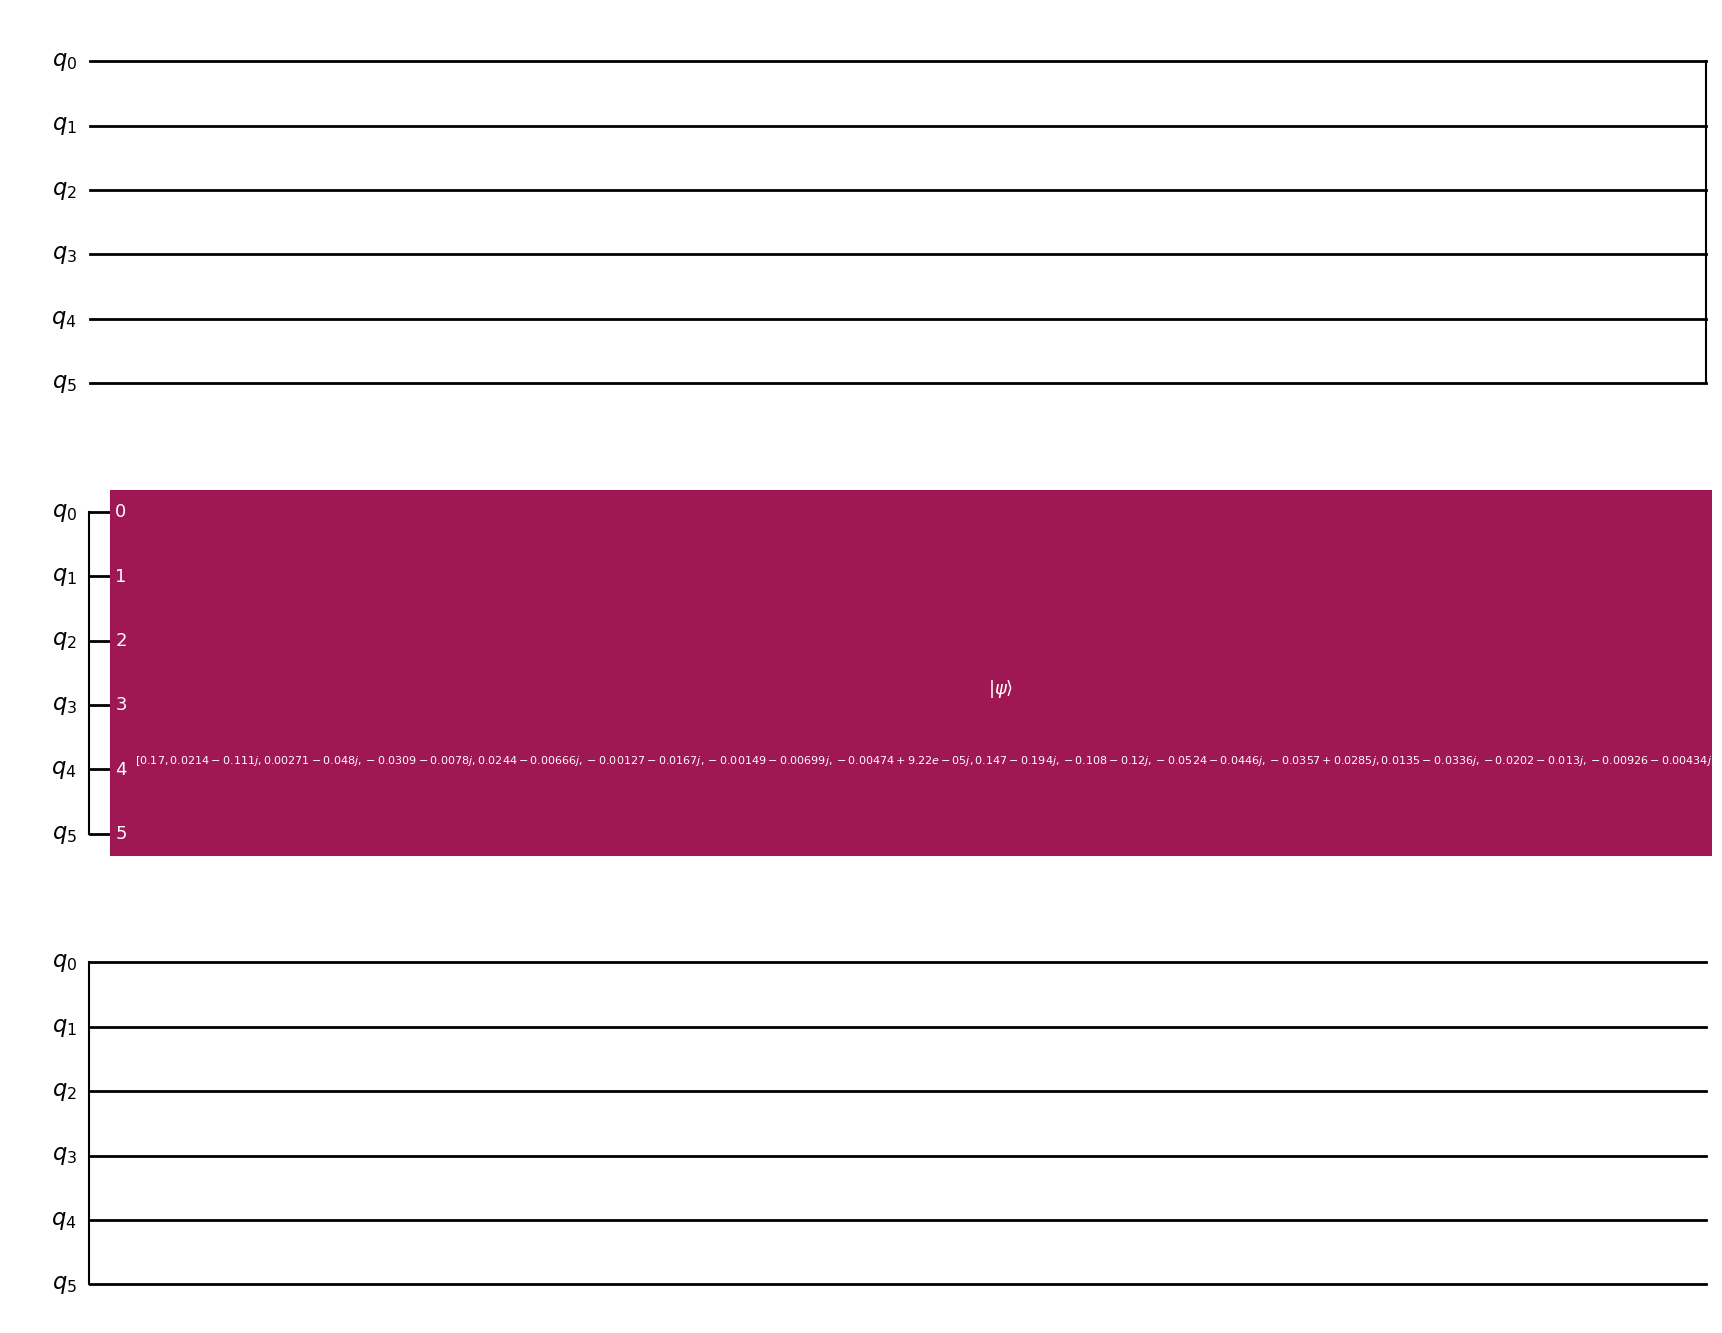

In [18]:
qc_test = random_product_state(N)
print(qc_test.num_qubits)

qc_test.draw(output='mpl')

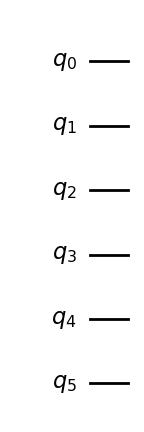

In [19]:
qc_check = QuantumCircuit(N)
qc_check.draw(output='mpl')

In [27]:
def random_state_circuit(N,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    c = random_product_state(N)
    fermi_state_up = c
    fermi_state_down = c
    qc.initialize(fermi_state_up,range(N))
    qc.initialize(fermi_state_down,range(N+1,2*N+1))
    return qc

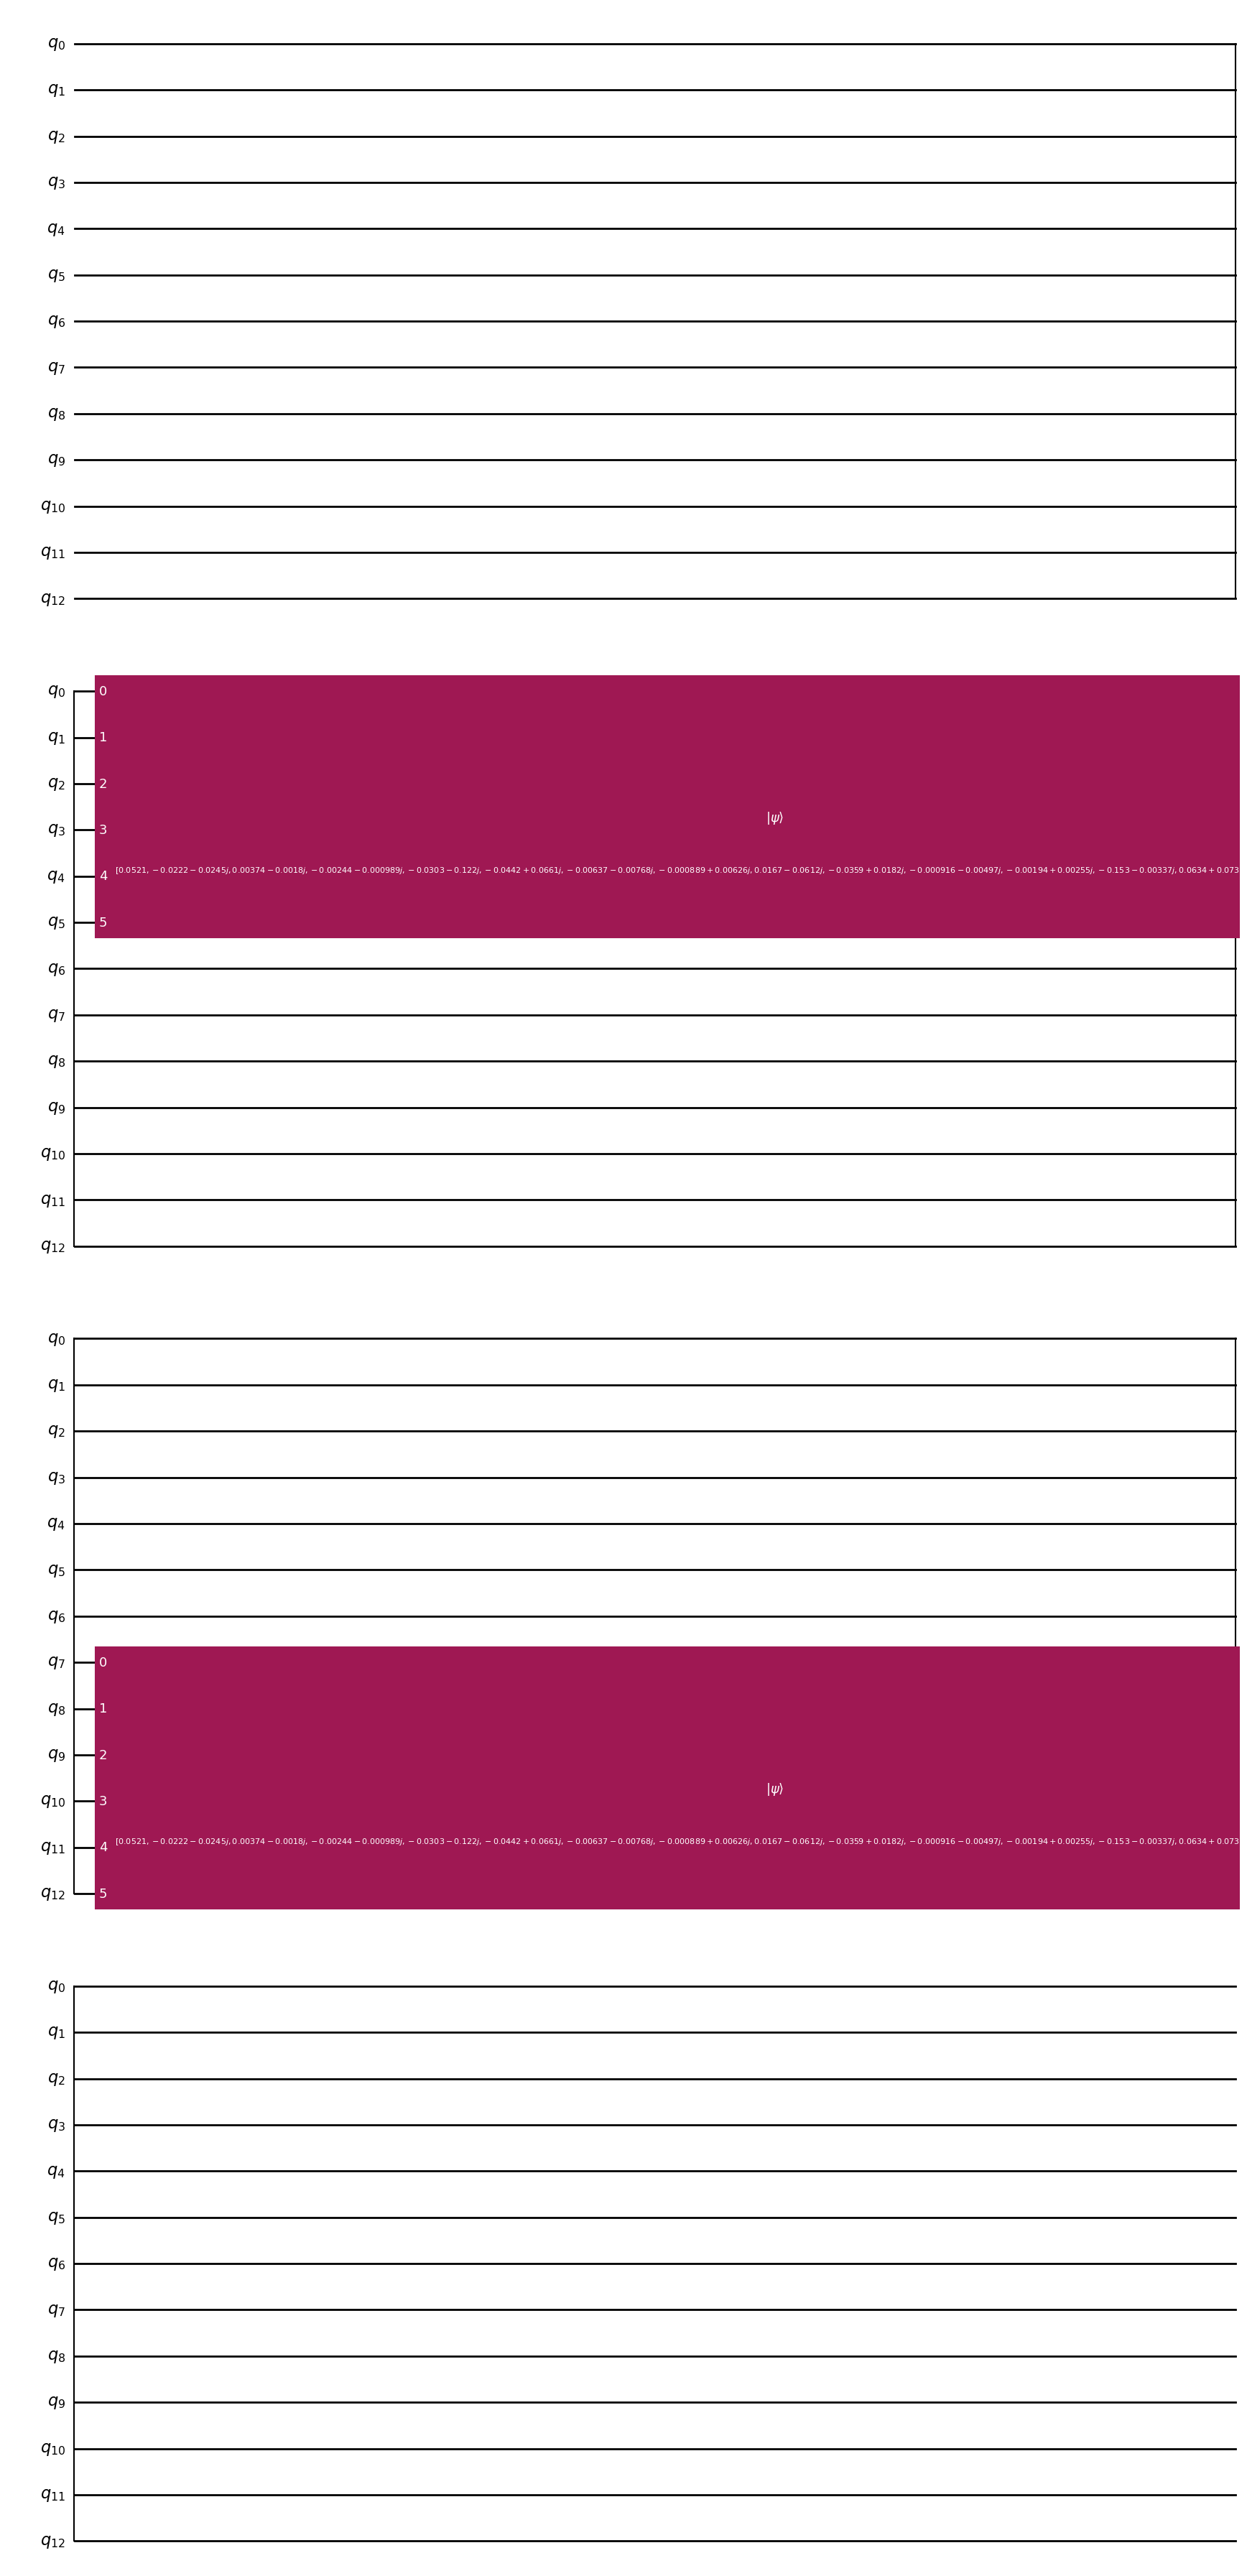

In [28]:
qc_check = random_state_circuit(N)
qc_check.draw(output='mpl')

In [32]:
import math as m
import cmath as cm

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def add_fsim_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)
    fsim2 = fsim(2*theta,0,0)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

def add_fsim_inv_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)

        
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

def add_fsim_full(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)
    fsim2 = fsim(2*theta,0,0)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

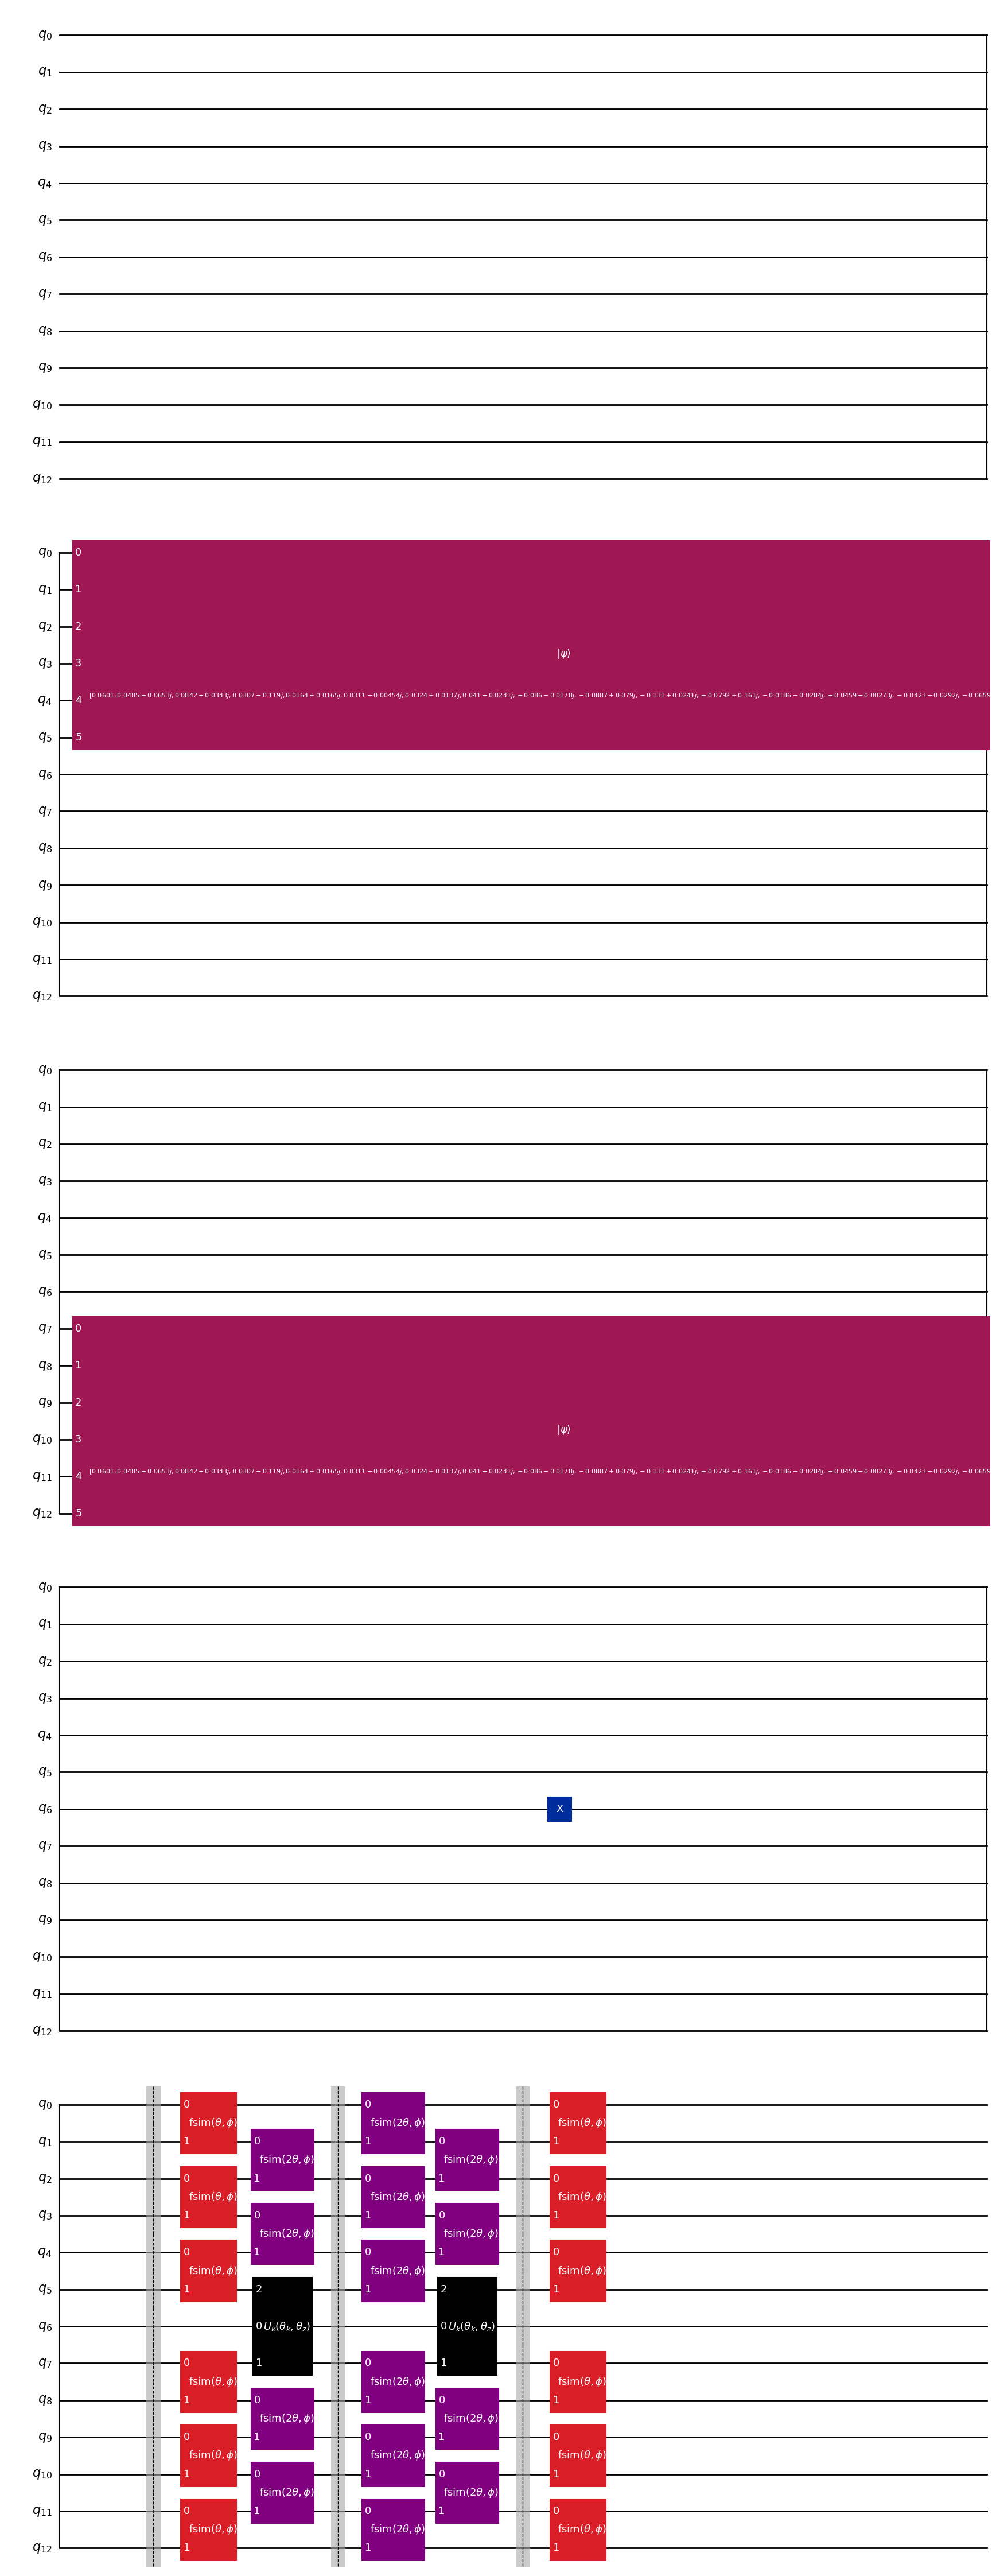

In [33]:
test_trotter_steps = 2
angles = np.pi/4


#Now we add the entire kondo circuit. This is the more efficient layered version as seen in our discussion

# Let us use the direct 8 by 8 unitary now for the problem

def kondo_unitary(theta_k,theta_z):

    l1 = cm.exp(1j*theta_z/2)
    l2 = cm.exp(-1j*theta_z/2)
    c1 = m.cos(theta_k)
    s1 = m.sin(theta_k)

    a = m.cos(np.sqrt(2)*theta_k) - (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    a_dag = m.cos(np.sqrt(2)*theta_k) + (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    b = (-1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    c = cm.exp(-1j*theta_k) 
    d = cm.exp(1j*theta_k)

    """kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,l1,0,0,0,0,0],
                          [0,0,0,c1*l2,1j*l2*s1,0,0,0],
                          [0,0,0,1j*l2*s1,c1*l2,0,0,0],
                          [0,0,0,0,0,l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])"""
    kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,a,0,0,0,0,b,0],
                          [0,0,1,0,0,0,0,0],
                          [0,0,0,d,0,0,0,0],
                          [0,0,0,0,c,0,0,0],
                          [0,0,0,0,0,1,0,0],
                          [0,b,0,0,0,0,a_dag,0],
                          [0,0,0,0,0,0,0,1]])
    
    kondo_unitary_2 = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,c1*l1,0,0,1j*s1*l1,0,0],
                          [0,0,0,l2,0,0,0,0],
                          [0,0,0,0,l2,0,0,0],
                          [0,0,1j*s1*l1,0,0,c1*l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    
    return kondo_unitary_2

def circuit_3(N, pos_list, trotter_steps,angles = 0,theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False, save = False):
    if num_cl_bits == 0:
        qc = random_state_circuit(N)
    else:
        qc = random_state_circuit(N,num_cl_bits)
    qc.x(N)
    qc.barrier()
    
    c = num_qubits//2
    add_fsim_half(qc,angles)
    qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
    if trotter_barriers:
            qc.barrier()
    for i in range(1,trotter_steps):
        add_fsim_full(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
       
        if trotter_barriers:
            qc.barrier()
    add_fsim_inv_half(qc,angles)
    if save == True:
        qc.save_statevector()
    #qc.save_statevector()  remove save for changing to operator
    return qc

qc = circuit_3(N,[2*N],test_trotter_steps,angles,trotter_barriers = True)


gate_colours = {
    "displaycolor": {
        r'fsim$(2\theta,\phi)$': [ # gate name
            "#800080", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'fsim$(\theta,\phi)$': [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'$U_{k}(\theta_k,\theta_z)$': [ # gate name
            "#000000", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
    },
}
qc.draw(output = 'mpl',style = gate_colours)

In [34]:
estimator = Estimator(approximation=True)
sampler = Sampler()

In [35]:
theta = np.pi/4
theta_k = np.pi/6

In [38]:
def plot_mag_impurity(super_qc_list_20,qc_list2,qc_list3):
    for i in range(len(super_qc_list_20)):
        theta = super_qc_list_20[i][1]
        theta_k = super_qc_list_20[i][2]
        qc_list1 = super_qc_list_20[i][0]
        qc_list2 = qc_list2[i][0]
        qc_list3 = qc_list3[i][0]
        imp_observables = [SparsePauliOp('I'*N + 'Z' + 'I'*N)]*100
        job_1 = estimator.run(qc_list1,imp_observables,shots = None)
        job_2 = estimator.run(qc_list2,imp_observables,shots = None)
        job_3 = estimator.run(qc_list3,imp_observables,shots = None)
        expectation_list_1 = list(job_1.result().values)
        expectation_list_2 = list(job_2.result().values)
        expectation_list_3 = list(job_3.result().values)
        plt.plot(range(100),expectation_list_1,label = 'State1')
        plt.plot(range(100),expectation_list_2,label = 'State2')
        plt.plot(range(100),expectation_list_3,label = 'State3')
        plt.title(f'Impurity Magnetization for Theta = {round(theta,2)} and Theta_k = {round(theta_k,2)}')
        plt.xlabel('Time (Trotter Steps)')
        plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
        plt.legend()
        plt.show()

H_t = 0
H_k = 0
for i in range(2*N):
    if i==N-1 or i==N:
        continue
    else:
        H_t += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(2*N-i-1)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(2*N-i-1)))
H_k = (-theta_k/2)*(SparsePauliOp('I'*(N-1) + 'XXX' + 'I'*(N-1))+SparsePauliOp('I'*(N-1) + 'YXY' + 'I'*(N-1)) + SparsePauliOp('I'*(N-1) + 'XYY' + 'I'*(N-1))- SparsePauliOp('I'*(N-1) + 'YYX' + 'I'*(N-1))+ SparsePauliOp('I'*(N) + 'ZZ' + 'I'*(N-1)) - SparsePauliOp('I'*(N-1) + 'ZZ' + 'I'*(N)))

def plot_hexp(super_qc_list_50,qc_list2,qc_list3):
    for i in range(len(super_qc_list_50)):
        theta = super_qc_list_50[i][1]
        theta_k = super_qc_list_50[i][2]
        qc_list1 = super_qc_list_50[i][0]
        qc_list2 = qc_list2[i][0]
        qc_list3 = qc_list3[i][0]

        h_analytical = [H_t + H_k]*100
        #print("Operator obtained from circuit")
        job_analytical1 = estimator.run(qc_list1,h_analytical,shots = None)
        job_analytical2 = estimator.run(qc_list2,h_analytical,shots = None)
        job_analytical3 = estimator.run(qc_list3,h_analytical,shots = None)
        h_values1 = list(job_analytical1.result().values)
        h_values2 = list(job_analytical2.result().values)
        h_values3 = list(job_analytical3.result().values)

        plt.plot(range(100),h_values1,label = 'State1')
        plt.plot(range(100),h_values2,label = 'State2')
        plt.plot(range(100),h_values3,label = 'State3')
        plt.xlabel('Time (trotter steps)')
        plt.ylabel(r'$\langle H(t) \rangle$')
        plt.title(f'Hamiltonian Expectation for Theta = {round(theta,2)} and Theta_k = {round(theta_k,2)}')
        plt.legend()
        plt.show()


In [36]:
qc_list1 = []
qc_list2 = []
qc_list3 = []

measured_bits =list(range(2*N + 1))

theta_z = -theta_k
qc_list_1 = []
qc_list_2 = []
qc_list_3 = []


for t in range(100):
    qc1 = circuit_3(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)

    qc2 = circuit_3(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
    qc3 = circuit_3(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
    qc_list_1.append(qc1)
    qc_list_2.append(qc2)
    qc_list_3.append(qc3)
qc_list1.append((qc_list_1,theta,theta_k))
qc_list2.append((qc_list_2,theta,theta_k))
qc_list3.append((qc_list_3,theta,theta_k))





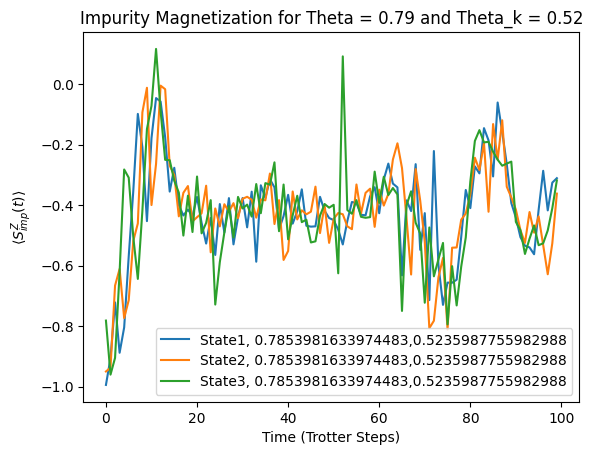

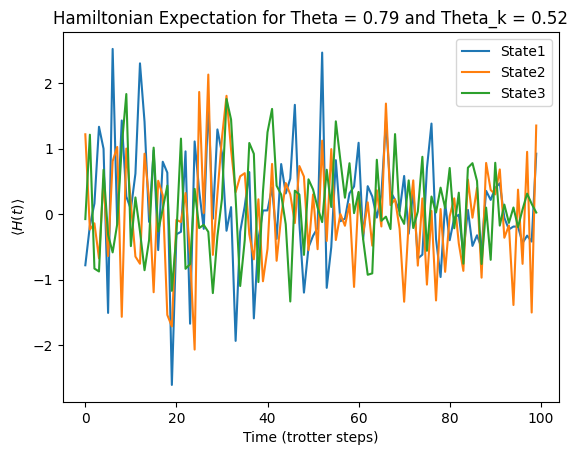

In [39]:
plot_mag_impurity(qc_list1,qc_list2,qc_list3)
plot_hexp(qc_list1,qc_list2,qc_list3)